# Imports

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tokenization.word_tokenizer import WordTokenizer
from data_utils.data_utils import *

In [60]:
MAX_VOCAB_SIZE = 10_000
MAX_LEN = 256
SEED = 42
EPOCHS = 5

# Prepocess Data

## Load Data

In [46]:
train_data = load_dataset('stanfordnlp/imdb', split="train[:80%]")
val_data = load_dataset('imdb', split="train[80%:]")
test_data = load_dataset('imdb', split="test")

## Tokenize Data

In [48]:
tokenizer = WordTokenizer(train_data['text'], MAX_VOCAB_SIZE, MAX_LEN)
train_tokens = tokenizer(train_data['text'])
val_tokens = tokenizer(val_data['text'])
test_tokens = tokenizer(test_data['text'])

## Pad Data

In [49]:
pad_token = tokenizer.get_pad_token()
train_padded = pad_sequences(train_tokens, pad_token, MAX_LEN)
val_padded = pad_sequences(val_tokens, pad_token, MAX_LEN)
test_padded = pad_sequences(test_tokens, pad_token, MAX_LEN)

## Create Datasets

In [50]:
class IMDBDataset(Dataset):
    def __init__(self, text, lbls):
        self.text = text
        self.lbls = lbls

    def __len__(self):
        return len(self.lbls)

    def __getitem__(self, index):
        return torch.tensor(self.text[index]), torch.tensor(self.lbls[index])

In [51]:
train_set = IMDBDataset(train_padded, train_data['label'])
val_set = IMDBDataset(val_padded, val_data['label'])
test_set = IMDBDataset(test_padded, test_data['label'])

# Create Group Sampler

The group sampler returns data sorted by the length. TODO

In [52]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

# Collate function

TODO

# Build Model

In [53]:
class RNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, dropout: float):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.embedding(x))
        x, (_, _) = self.lstm(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return torch.sigmoid(x).squeeze(1)

In [55]:
model = RNN(vocab_size=MAX_VOCAB_SIZE, embedding_dim=MAX_LEN, hidden_dim=256, dropout=0.5)

# Training Loop

In [54]:
def process_epoch(model: torch.nn.Module, loader: torch.utils.data.DataLoader, crit: torch.nn.Module,
                 device: torch.device, optimizer: torch.optim.Optimizer = None):
    """
    Processes one training or validation step for a given model.
    :param model: The neural network model.
    :param loader: The data loader providing batches of input sequences and labels.
    :param crit: The loss function used to compute the loss.
    :param device: The device on which computations will be performed (e.g., 'cuda' or 'cpu').
    :param optimizer: The optimizer used for training. If None, the function runs in evaluation mode.
    :return: tuple: (avg_epoch_loss, accuracy)
            - avg_epoch_loss (float): The average loss over all batches in the epoch.
            - accuracy (float): The classification accuracy over all samples.
    """
    train = optimizer is not None
    if train:
        model.train()
    else:
        model.eval()

    avg_epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for seqs, labels in tqdm(loader, desc="Training" if train else "Validation"):
        seqs, labels = seqs.to(device), labels.float().to(device)

        if train:
            # Clear gradients from last step
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            # Get new predictions for one input batch
            pred = model(seqs)
            # Calculate the difference between the true labels and the predicted ones using the loss function
            loss = crit(pred, labels)

            if train:
                # Compute gradients via backpropagation
                loss.backward()
                # Update the model parameters
                optimizer.step()

        avg_epoch_loss += loss.item()
        correct_preds += (pred >= 0.5).eq(labels).sum().item()
        total_preds += labels.size(0)

    avg_epoch_loss /= len(loader)
    accuracy = correct_preds / total_preds

    return avg_epoch_loss, accuracy

# Train Model

In [56]:
# Use GPU for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [58]:
model.to(device)

RNN(
  (embedding): Embedding(10000, 256, padding_idx=0)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [61]:
metrics = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch': []
}
for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = process_epoch(model, train_loader, criterion, device, optimizer)

    # Evaluate
    with torch.no_grad():
        val_loss, val_acc = process_epoch(model, val_loader, criterion, device)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    metrics['epoch'].append(epoch)

Validation: 100%|██████████| 157/157 [00:04<00:00, 37.13it/s]


# Test and Plot Results

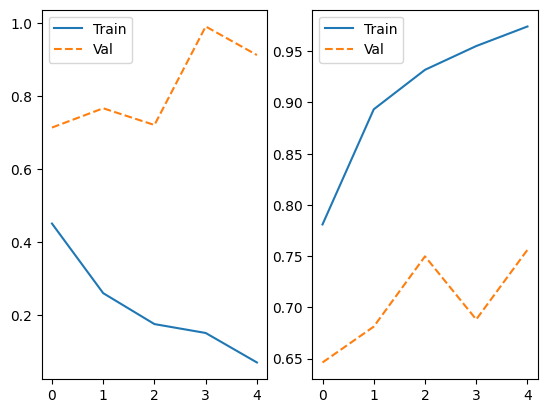

In [62]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(metrics['epoch'], metrics['train_loss'], label='Train')
ax[0].plot(metrics['epoch'], metrics['val_loss'], '--', label='Val')

ax[1].plot(metrics['epoch'], metrics['train_acc'], label='Train')
ax[1].plot(metrics['epoch'], metrics['val_acc'], '--', label='Val')

ax[0].legend()
ax[1].legend()